# SC1015 MINI-PROJECT

OBJECTIVE: TO FIND THE BEST METHODOLOGY IN PREDICTING STOCK PRICES

SECTION 1: IMPORTING NECESSARY LIBRARIES

SECTION 2: DATA PREPROCESSING

SECTION 3: RMSE AND MAPE

SECTION 4: DIVIDING TRAIN AND TEST DATA

SECTION 5: #1 NAIVE

SECTION 6: #2 MA-30; MA-50; MA-200

SECTION 7: #3 Exponential Smoothing

SECTION 8: #4 LSTM

SECTION 9: CONCLUSION

# SECTION 1 - IMPORTING NECESSARY LIBRARIES

In [69]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#essential for LSTM model
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# SECTION 2 - DATA PREPROCESSING

In [70]:
stock_cleaned_data=pd.read_csv('../data/stock_cleaned_data.csv', index_col = 0)

In [71]:
stock_cleaned_data.head()

,open,high,low,close,adjclose,volume
date,,,,,,
2023-04-18,415.58,415.72,412.7802,414.21,414.21,63559997
2023-04-17,412.37,413.96,411.0850,413.94,413.94,65496534
2023-04-14,412.81,415.09,410.0600,412.46,412.46,78161500
2023-04-13,409.18,413.84,407.9922,413.47,413.47,85814754
2023-04-12,411.87,412.17,407.4400,408.05,408.05,86420379


In [72]:
stock_cleaned_data.index

Index(['2023-04-18', '2023-04-17', '2023-04-14', '2023-04-13', '2023-04-12',
       '2023-04-11', '2023-04-10', '2023-04-06', '2023-04-05', '2023-04-04',
       ...
       '1999-11-12', '1999-11-11', '1999-11-10', '1999-11-09', '1999-11-08',
       '1999-11-05', '1999-11-04', '1999-11-03', '1999-11-02', '1999-11-01'],
      dtype='object', name='date', length=5903)

In [73]:
stock_cleaned_data = stock_cleaned_data[::-1]
stock_cleaned_data.head()

,open,high,low,close,adjclose,volume
date,,,,,,
1999-11-01,136.500000,137.000000,135.562500,135.562500,88.217185,4006500
1999-11-02,135.968704,137.250000,134.593704,134.593704,87.586742,6516900
1999-11-03,136.000000,136.375000,135.125000,135.500000,88.176513,7222300
1999-11-04,136.750000,137.359299,135.765594,136.531204,88.847568,7907500
1999-11-05,138.625000,139.109299,136.781204,137.875000,89.722043,7431500


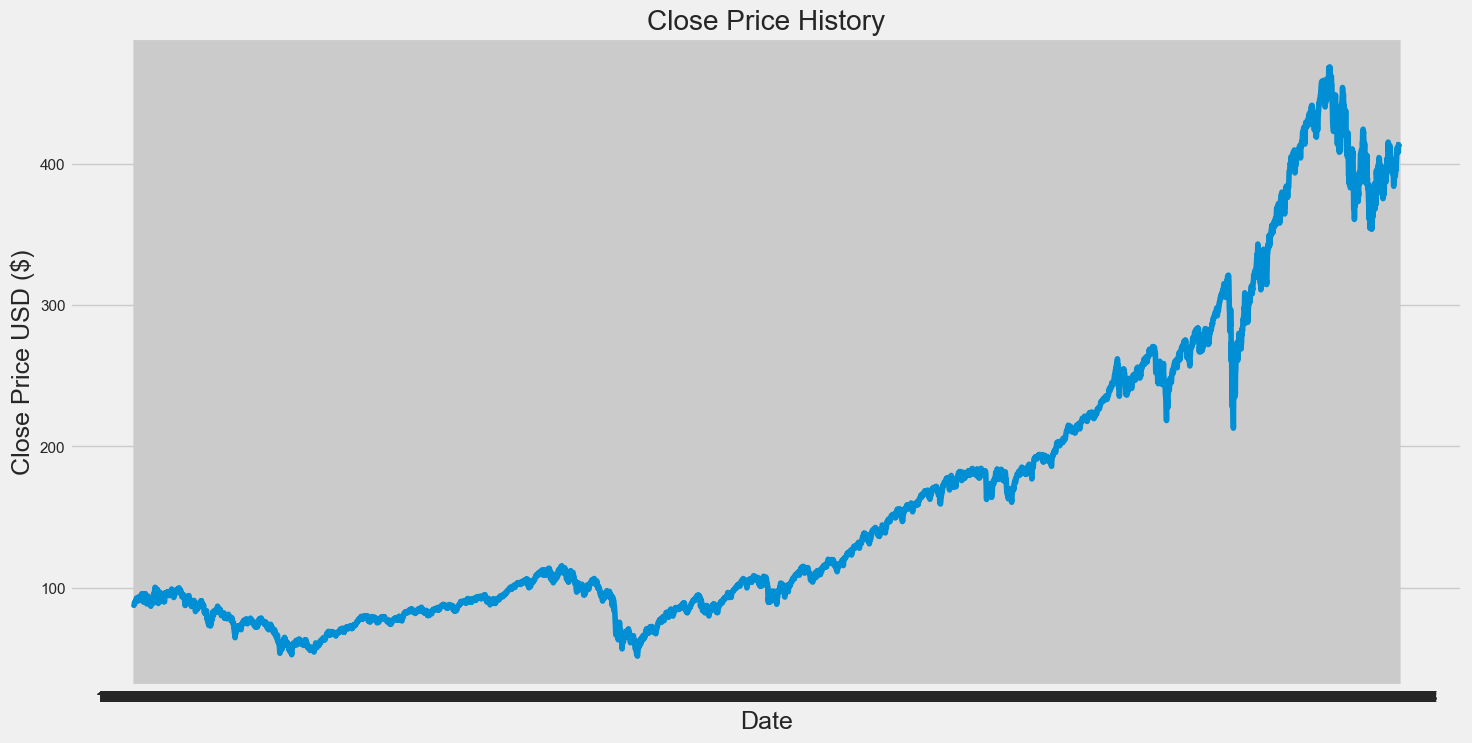

In [74]:
#plot the stock price graph
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(stock_cleaned_data['adjclose'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

# SECTION 3 - RMSE AND MAPE

In [75]:
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                   
    return rmse

### The effectiveness of prediction method is measured in terms of the Mean Absolute Percentage Error (MAPE) and RMSE
def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

# SECTION 4 - DIVIDING TRAIN AND TEST DATA

**LSTM model**

In [76]:
data=stock_cleaned_data.filter(['close'])
dataset=data.values
training_data_len=math.ceil(len(dataset)*.8)
training_data_len

4723

In [77]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
scaled_data

array([[0.16467895],
       [0.16231373],
       [0.16452637],
       ...,
       [0.84069824],
       [0.84431152],
       [0.8449707 ]])

In [78]:
train_data=scaled_data[0:training_data_len, : ]
x_train= []
y_train= []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

# SECTION 5 - #1 NAIVE

In [254]:
data=stock_cleaned_data.filter(['close'])
dataset=data.values
test_data_len=len(dataset)-math.ceil(len(dataset)*.8)
print("testing data size:", test_data_len)

test_data = dataset[-test_data_len:, : ]

testing data size: 1180


In [255]:
initial_forecast = dataset[training_data_len-1]
naive_pred = [initial_forecast]

for i in range(0, test_data_len-1):
    naive_pred.append(test_data[i])

In [256]:
calculate_rmse(test_data, naive_pred)

4.617054503483318

In [82]:
calculate_mape(test_data, naive_pred)

0.9199074740856902

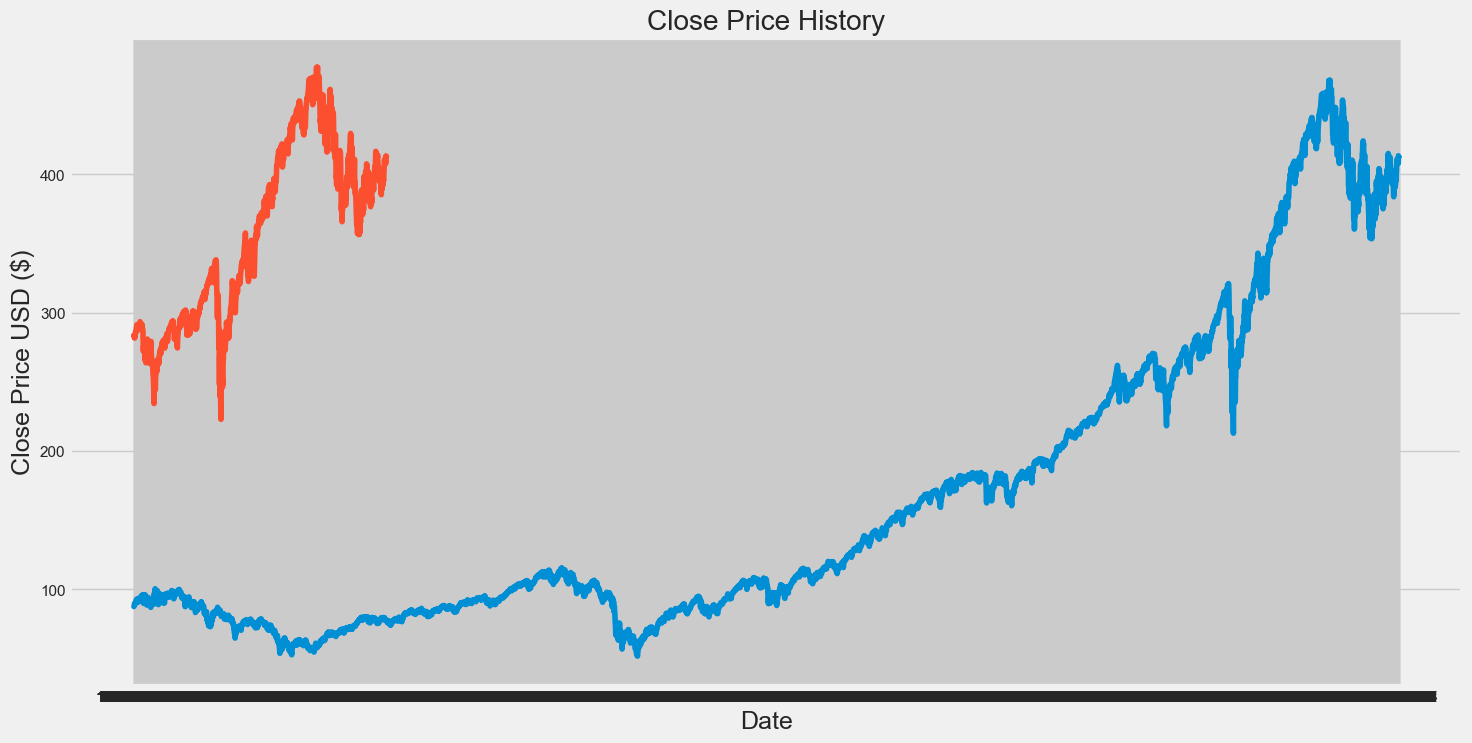

In [257]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(stock_cleaned_data['adjclose'])
plt.plot(naive_pred)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

# SECTION 6 - #2 MA-30; MA-50; MA-200

In [160]:
grid = [5, 10, 20, 30, 50, 100, 200]

data=stock_cleaned_data.filter(['close'])
dataset=data.values
test_data_len=len(dataset)-math.ceil(len(dataset)*.8)
print("testing data size:", test_data_len)
test_data = dataset[-test_length:, : ]

testing data size: 1180


In [184]:
def MA(dataset, test_length, window_size):
    MA_pred = []
    
    for i in range(test_length, 0, -1):
        MA_pred.append(np.mean(dataset[(-i- window_size):(-i-1)]))
    
    return MA_pred

In [187]:
def calculate_ma(dataset, test_length, window_size):
    # Calculate the moving average using the specified window size
    ma_pred = []
    for i in range(window_size, len(dataset)):
        window_start = i - window_size
        window_end = i
        ma_pred.append(np.mean(dataset[window_start:window_end]))
    
    # Return the last 'test_length' MA predictions
    return ma_pred[-test_length:]


In [189]:
Z = calculate_ma(dataset, test_data_len, 10)

In [190]:
calculate_rmse(Z, test_data)

90.52285992790995

In [172]:
test_length = test_data_len
test_data = dataset[-test_length:, : ]
MA_pred = []
    
for i in range(test_length, 0, -1):
    MA_pred.append(np.mean(dataset[(-i- 10):(-i-1)]))

In [179]:
calculate_rmse(test_data, MA_pred)

90.54524458669123

In [152]:
test_data[401], MA_pred[401]

(array([239.85]),
 close    289.692222
 dtype: float64)

In [158]:
calculate_rmse(test_data, MA_pred)

9.079042334419993

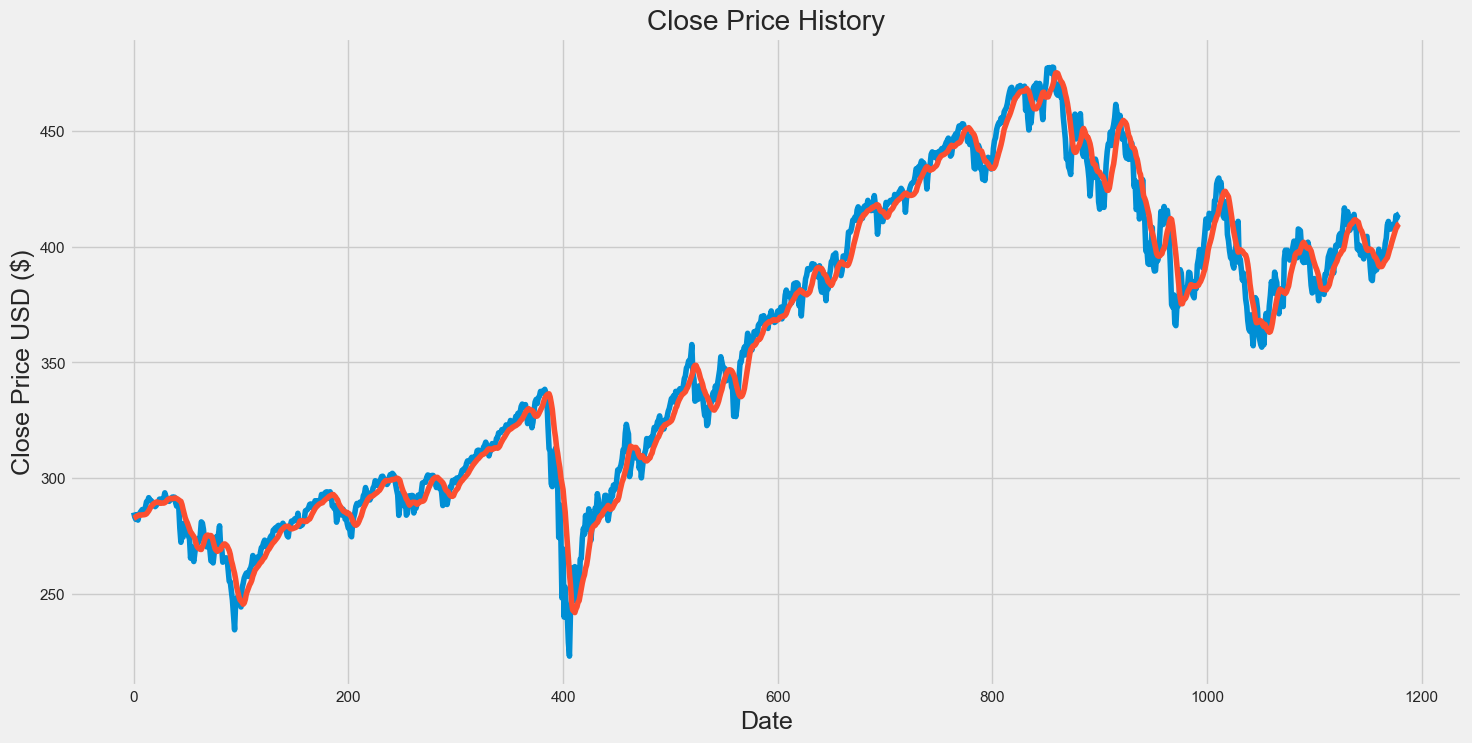

In [157]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(test_data)
plt.plot(MA_pred)

plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [174]:
for windowsize in grid:
    MA(dataset, test_data_len, windowsize)

RMSE of window size 5: 90.59825536076961
MAPE of window size 5: 21.31281551628218

RMSE of window size 10: 90.54524458669123
MAPE of window size 10: 21.287325931069184

RMSE of window size 20: 90.45655156961062
MAPE of window size 20: 21.23897569022063

RMSE of window size 30: 90.39341752634712
MAPE of window size 30: 21.192947245367165

RMSE of window size 50: 90.31820555865994
MAPE of window size 50: 21.1100078363034

RMSE of window size 100: 90.36734180310069
MAPE of window size 100: 20.978418580327276

RMSE of window size 200: 90.68761349062261
MAPE of window size 200: 20.84577019154544



# SECTION 7 - #3 EXPONENTIAL SMOOTHING

In [223]:
data=stock_cleaned_data.filter(['close'])
dataset=data.values

training_data_len=math.ceil(len(dataset)*.8)
test_data_len = len(dataset) - training_data_len

training_data = dataset[0:training_data_len, :]
test_data = dataset[training_data_len:, :]
training_data_len,test_data_len, len(training_data), len(test_data)

(4723, 1180, 4723, 1180)

**Exponential smoothing without trend**

In [248]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
alpha = 0.5

model = ExponentialSmoothing(training_data, trend=None, seasonal=None, initialization_method='estimated')
model_fit = model.fit(smoothing_level=alpha)

ES_pred = model_fit.forecast(test_data_len)

In [249]:
len(ES_pred), len(test_data)

(1180, 1180)

In [250]:
calculate_rmse(ES_pred, test_data)

96.38064883228759

In [252]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# create the SimpleExpSmoothing model with alpha=0.5
model = SimpleExpSmoothing(training_data)
model_fit = model.fit(smoothing_level=0.5)

# make predictions for the next 10 time steps
predictions = model_fit.forecast(test_data_len)

In [253]:
calculate_rmse(test_data, predictions)

96.38064883228759

# SECTION 8 - #4 LSTM

In [86]:
x_train,y_train=np.array(x_train),np.array(y_train)

In [87]:
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(4663, 60, 1)

In [88]:
#Build the LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [89]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [90]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

4663/4663 [==============================] - 99s 20ms/step - loss: 1.9549e-04


In [91]:
#Create the testing dataset
test_data=scaled_data[training_data_len - 60: , :]
x_test=[]
y_test=dataset[training_data_len:, : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [92]:
x_test=np.array(x_test)

In [93]:
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [94]:
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

37/37 [==============================] - 2s 14ms/step


In [95]:
calculate_rmse(y_test,predictions)

7.923594484600173

In [96]:
calculate_mape(y_test,predictions)

1.6622129346409362

C:\Users\jerem\AppData\Local\Temp\ipykernel_5164\2011643448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions']=predictions


<function matplotlib.pyplot.show(close=None, block=None)>

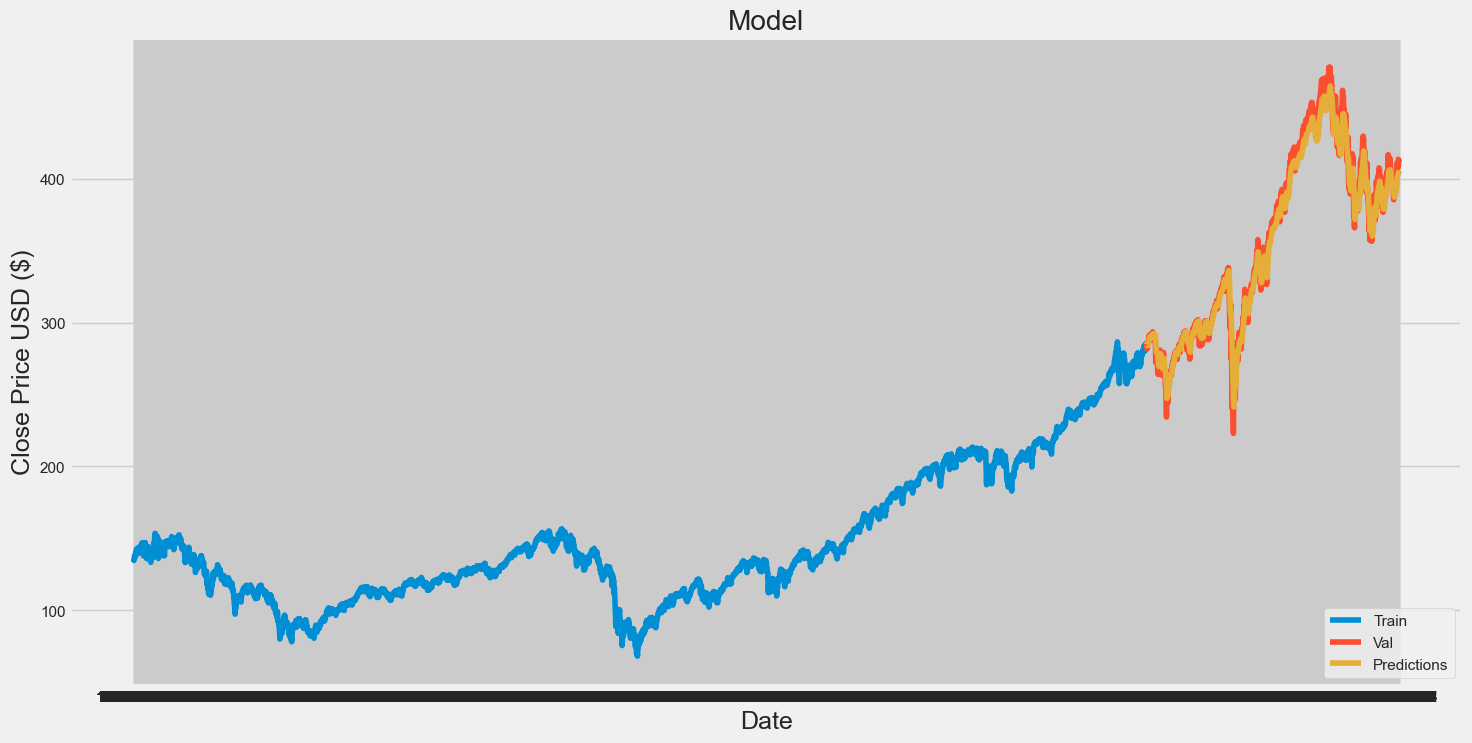

In [97]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show

# SECTION 9 - CONCLUSION